# Training an SNN with fewer SynOps
In the previous tutorial we saw how we can train an ANN with a low number of synaptic operations (SynOps). The same can be done when training an SNN directly. Let's start by defining a spiking model. 

In [1]:
import torch
import torch.nn as nn
import sinabs
import sinabs.layers as sl

# Seed for reproducibility
torch.manual_seed(1)

class SNN(nn.Sequential):
    def __init__(self, batch_size):
        super().__init__(
            sl.FlattenTime(),
            nn.Conv2d(1, 16, 5, bias=False),
            sl.IAFSqueeze(batch_size=batch_size),
            sl.SumPool2d(2),
            nn.Conv2d(16, 32, 5, bias=False),
            sl.IAFSqueeze(batch_size=batch_size),
            sl.SumPool2d(2),
            nn.Conv2d(32, 120, 4, bias=False),
            sl.IAFSqueeze(batch_size=batch_size),
            nn.Flatten(),
            nn.Linear(120, 10, bias=False),
            sl.IAFSqueeze(batch_size=batch_size),
            sl.UnflattenTime(batch_size=batch_size),
        )

batch_size = 5
snn = SNN(batch_size=batch_size)

Let's make our SNN track how many synaptic operations it generates during a single sample. We can use the same function as in the previous tutorial to set up the corresponding hooks.

In [2]:
from sinabs.hooks import register_synops_hooks

# Register the hooks with our ANN
register_synops_hooks(snn)

# Forward pass to record the number of synaptic operations
rand_input_spikes = (torch.ones((batch_size, 10, 1, 28, 28)) ).float()
snn(rand_input_spikes)

print("Synops after feeding input:")
print(f"Total: {snn.hook_data['total_synops_per_timestep']:.2e} SynOps per step")

Synops after feeding input:
Total: 1.22e+06 SynOps per step


You can also break down the statistics for each convolutional or linear layer.

In [3]:
print("Per layer:")
for layer_idx, synops in snn.hook_data['synops_per_timestep'].items():
    print(f"- Layer {layer_idx}: {synops:.2e} SynOps per step")

Per layer:
- Layer 1: 2.30e+05 SynOps per step
- Layer 4: 9.01e+05 SynOps per step
- Layer 7: 8.83e+04 SynOps per step
- Layer 10: 7.31e+02 SynOps per step


Once we can calculate the total number of synaptic operations, we might want to choose a target SynOps number as part of our objective function. This time, let's optimize each layer individually, rather than their sum. We will set a target of 500'000 operations per layer.

In [4]:
# Helper functions to calculate the SynOp loss for each layer

def get_synops_squared_error(synops, target_synops):
    """ Loss term for individual layer:
    Squared error on anything above the target
    """
    # Use ReLU so that only values above taret are punished
    above_target = nn.functional.relu(synops - target_synops)
    # Return squared error
    return above_target**2
    
def get_synops_loss(snn, target_synops):
    """ Sum of synop losses of individual layers"""
    loss = sum(
        get_synops_squared_error(synops, target_synops)
        for synops in snn.hook_data["synops_per_timestep"].values()
    )
    return loss        

In [5]:
# Choose the target number of operations
target_synops = 1e5
synops_loss_weight = 1e-0

optim = torch.optim.Adam(snn.parameters(), lr=1e-3)

synops_per_layer = {idx: [] for idx in (1, 4, 7, 10)}
for epoch in range(100):
    sinabs.reset_states(snn)
    sinabs.zero_grad(snn)
    optim.zero_grad()
    
    snn(rand_input_spikes)
    
    synop_loss = synops_loss_weight * get_synops_loss(snn, target_synops)
    synop_loss.backward()
    optim.step()
    for idx, synops in snn.hook_data["synops_per_timestep"].items():
        synops_per_layer[idx].append(synops.item())

Text(0.5, 1.0, 'SynOps during training')

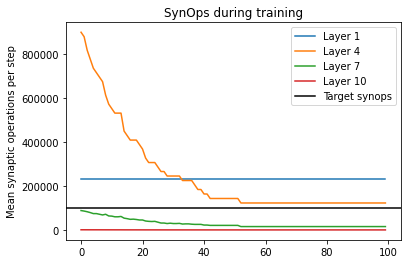

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for idx, synops in synops_per_layer.items():
    ax.plot(synops, label=f"Layer {idx}")
ax.axhline(y=target_synops, color='black', label="Target synops")
ax.set_ylabel("Mean synaptic operations per step")
ax.legend()
plt.title("SynOps during training")

We can see that the network quickly optimizes for the target number of synaptic operations. The synaptic operations for Layer 1 don't change because they depend entirely on the input and the shape of the layer, neither of which changes during training. SynOps for Layers 7 and 10 also decrease, even though they are already below the target. This is likely because the preceding Layer 4 is less active and our objective function is constant for SynOps values below the target.